In [6]:
import numpy as np
import torch
from mgw import PhiModel, train_phi
from mgw import pullback_metric_field, knn_graph, geodesic_distances, pairwise_squared_geodesic
from mgw import synthetic_multimodal_tissue
from mgw import solve_gw
from mgw import plot_alignment_lines, scatter_colored
from mgw import data, models, plotting

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
torch.set_default_dtype(torch.float32)


Using device: cuda:0


# Synthetic Example: 5 dimensional ("spatial transcriptomics") and 8 dimensional ("spatial metabolomics") alignment

In [7]:
sim = data.synthetic_multimodal_tissue(
    nx=36, ny=24, jitter=0.01, K=5, temp=0.07,
    warp_amp=0.05, dA=8, dB=5, batch_amp=(0.15, 0.2),
    noise=(0.03, 0.035), seed=3
)

s, t, X, Z = sim['s'], sim['t'], sim['X'], sim['Z']
labels, sigma = sim['labels'], sim['sigma']
print(f"Shapes: s={s.shape}, X={X.shape}, t={t.shape}, Z={Z.shape}")

Shapes: s=(864, 2), X=(864, 8), t=(864, 2), Z=(864, 5)


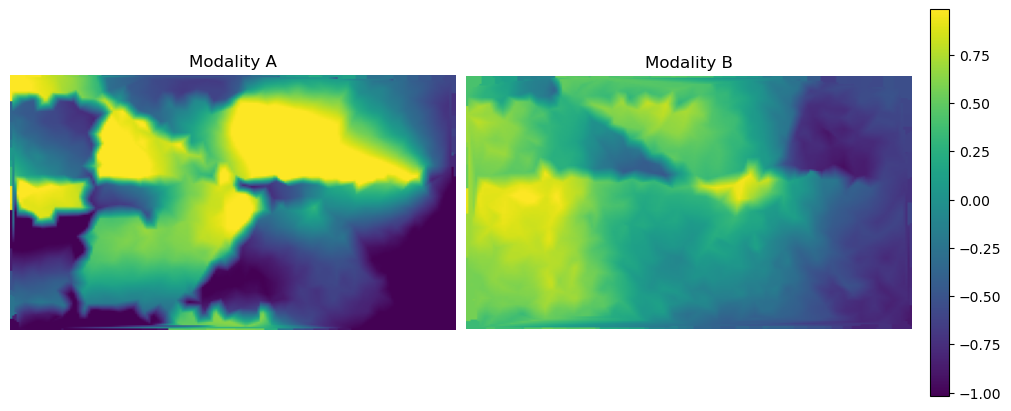

In [9]:
import matplotlib.pyplot as plt
import importlib
importlib.reload(plotting)

kA, kB = 0, 0
GXs, GYs, GAs = plotting.field_to_grid(s, X[:, kA])
GXt, GYt, GBs = plotting.field_to_grid(t, Z[:, kB])

finite = np.concatenate([GAs[np.isfinite(GAs)], GBs[np.isfinite(GBs)]])
lo, hi = np.percentile(finite, 5), np.percentile(finite, 95)

fig, ax = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)
for a, G, GX, GY, title in zip(ax, [GAs, GBs], [GXs, GXt], [GYs, GYt], ['Modality A', 'Modality B']):
    im = a.imshow(G, origin='lower', extent=[GX.min(), GX.max(), GY.min(), GY.max()],
                  cmap='viridis', vmin=lo, vmax=hi, aspect='equal')
    a.set_title(title); a.axis('off')
fig.colorbar(im, ax=ax, fraction=0.03, pad=0.02)
plt.show()


In [10]:
class ZScore:
    def fit(self, x):
        x = np.asarray(x, dtype=np.float32)
        self.mean = x.mean(0, keepdims=True)
        self.std = x.std(0, keepdims=True) + 1e-8
        return self
    def fwd(self, x): return (x - self.mean) / self.std
    def inv(self, z): return z * self.std + self.mean

# Apply normalization
S_s, S_t = ZScore().fit(s), ZScore().fit(t)
S_X, S_Z = ZScore().fit(X), ZScore().fit(Z)

s_tr, t_tr = S_s.fwd(s), S_t.fwd(t)
X_tr, Z_tr = S_X.fwd(X), S_Z.fwd(Z)

In [11]:
dim_e = s_tr.shape[1]
dim_f_M, dim_f_N = X_tr.shape[1], Z_tr.shape[1]

# Option 1: Basic model (fast)
phi = models.PhiModel(dim_e, dim_f_M, widths=(64, 128, 64))
psi = models.PhiModel(dim_e, dim_f_N, widths=(64, 128, 64))

phi = models.train_phi(phi, torch.from_numpy(s), torch.from_numpy(X),
                       lr=1e-3, niter=2000, print_every=200, device=device)
psi = models.train_phi(psi, torch.from_numpy(t), torch.from_numpy(Z),
                       lr=1e-3, niter=2000, print_every=200, device=device)

# Option 2: Fourier-feature model (more expressive)
"""
phi = models.PhiModelFFN(dim_e, dim_f_M, width=64, depth=3, fourier_m=64)
psi = models.PhiModelFFN(dim_e, dim_f_N, width=64, depth=3, fourier_m=64)
phi = models.train_phi_pro(phi, s_tr, X_tr, device=device, steps=12000, jac_reg=0)
psi = models.train_phi_pro(psi, t_tr, Z_tr, device=device, steps=12000, jac_reg=0)
"""

[train_phi] step=200 loss=0.264945
[train_phi] step=400 loss=0.205545
[train_phi] step=600 loss=0.164714
[train_phi] step=800 loss=0.124673
[train_phi] step=1000 loss=0.101993
[train_phi] step=1200 loss=0.089206
[train_phi] step=1400 loss=0.076638
[train_phi] step=1600 loss=0.068757
[train_phi] step=1800 loss=0.064387
[train_phi] step=2000 loss=0.061140
[train_phi] step=200 loss=0.107094
[train_phi] step=400 loss=0.092801
[train_phi] step=600 loss=0.064328
[train_phi] step=800 loss=0.046295
[train_phi] step=1000 loss=0.039482
[train_phi] step=1200 loss=0.036078
[train_phi] step=1400 loss=0.032070
[train_phi] step=1600 loss=0.029330
[train_phi] step=1800 loss=0.027376
[train_phi] step=2000 loss=0.029511


'\nphi = models.PhiModelFFN(dim_e, dim_f_M, width=64, depth=3, fourier_m=64)\npsi = models.PhiModelFFN(dim_e, dim_f_N, width=64, depth=3, fourier_m=64)\nphi = models.train_phi_pro(phi, s_tr, X_tr, device=device, steps=12000, jac_reg=0)\npsi = models.train_phi_pro(psi, t_tr, Z_tr, device=device, steps=12000, jac_reg=0)\n'

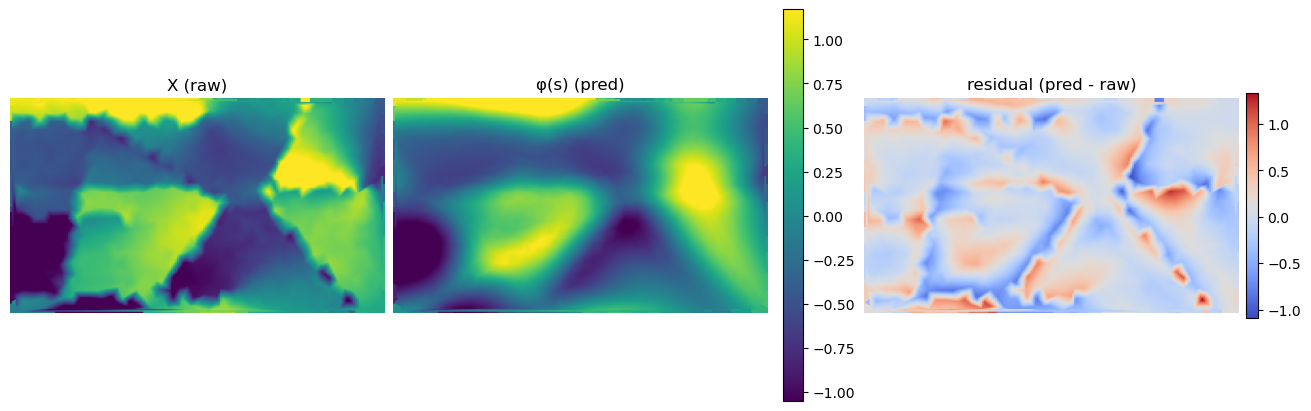

φ channel 1 {'mse': np.float32(0.12558022), 'r2': np.float32(0.76720166), 'corr': np.float64(0.8759873328628887)}


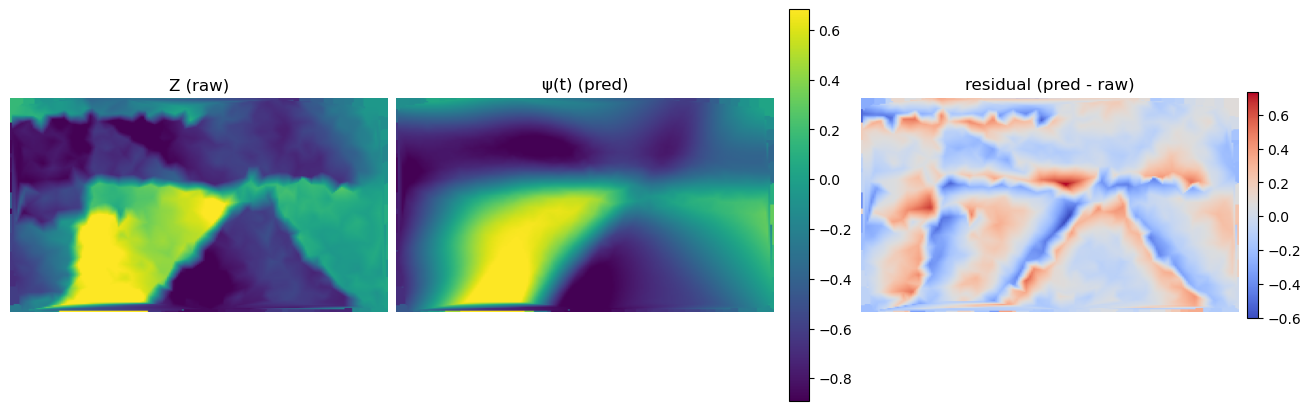

ψ channel 1 {'mse': np.float32(0.04168245), 'r2': np.float32(0.83998644), 'corr': np.float64(0.9170553083269636)}


In [13]:

# ----- For φ on (s, X) -----
k = 1  # pick feature channel
phi.eval()
X_pred = plotting.predict_on_model(phi, s)        # (n, d_M)
plotting.plot_fit_on_cloud(s, X[:,k], X_pred[:,k], title_true='X (raw)', title_pred='φ(s) (pred)')
print('φ channel', k, plotting.fit_metrics(X[:,k], X_pred[:,k]))

# ----- For ψ on (t, Z) -----
l = 1  # pick feature channel
psi.eval()
Z_pred = plotting.predict_on_model(psi, t)        # (m, d_N)
plotting.plot_fit_on_cloud(t, Z[:,l], Z_pred[:,l], title_true='Z (raw)', title_pred='ψ(t) (pred)')
print('ψ channel', l, plotting.fit_metrics(Z[:,l], Z_pred[:,l]))


In [14]:

G_M = pullback_metric_field(phi, torch.from_numpy(s).to(device), eps=1e-6)  # (n,2,2)
G_N = pullback_metric_field(psi, torch.from_numpy(t).to(device), eps=1e-6)  # (m,2,2)

G_M_cpu = G_M.cpu(); G_N_cpu = G_N.cpu()

G_s = knn_graph(s, k=12)
G_t = knn_graph(t, k=12)

D_M = geodesic_distances(s, G_M_cpu, G_s)  # (n,n)
D_N = geodesic_distances(t, G_N_cpu, G_t)  # (m,m)

C_M = pairwise_squared_geodesic(D_M).astype(np.float64)
C_N = pairwise_squared_geodesic(D_N).astype(np.float64)

print("C_M shape:", C_M.shape, "C_N shape:", C_N.shape)

C_M shape: (864, 864) C_N shape: (864, 864)


In [15]:
P = solve_gw(C_M, C_N, verbose=True, numItermax=200)
print("Coupling shape:", P.shape, "sum:", P.sum())

It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.076131e+03|0.000000e+00|0.000000e+00
    1|1.008058e+03|6.752941e-02|6.807354e+01
    2|8.348947e+02|2.074069e-01|1.731629e+02
    3|8.238893e+02|1.335783e-02|1.100537e+01
    4|8.232661e+02|7.570615e-04|6.232631e-01
    5|8.230144e+02|3.057872e-04|2.516673e-01
    6|8.228574e+02|1.908688e-04|1.570578e-01
    7|8.228236e+02|4.107543e-05|3.379783e-02
    8|8.228214e+02|2.647154e-06|2.178135e-03
    9|8.228163e+02|6.230322e-06|5.126410e-03
   10|8.228163e+02|4.709341e-09|3.874922e-06
   11|8.228163e+02|0.000000e+00|0.000000e+00
Coupling shape: (864, 864) sum: 0.9999999999999991


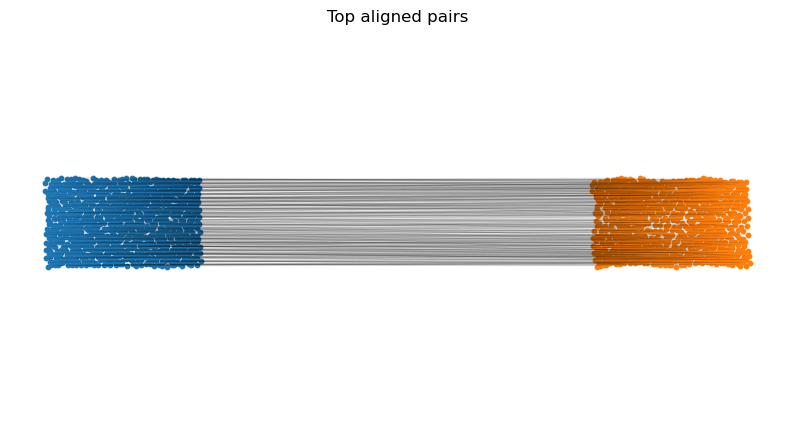

In [16]:
import importlib
from mgw import plotting
importlib.reload(plotting)
plotting.plot_alignment_lines(s, t, P, top=500, alpha=0.1)

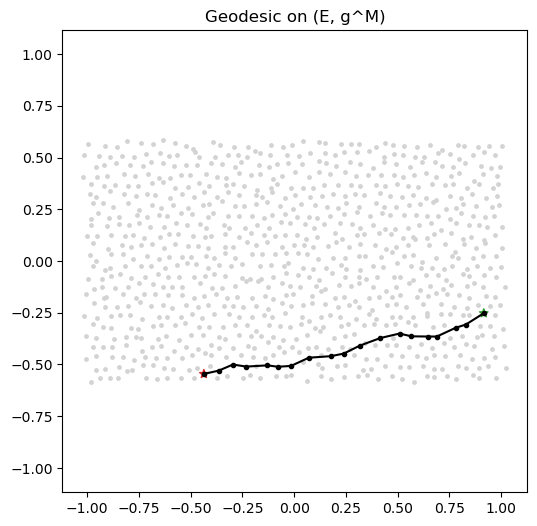

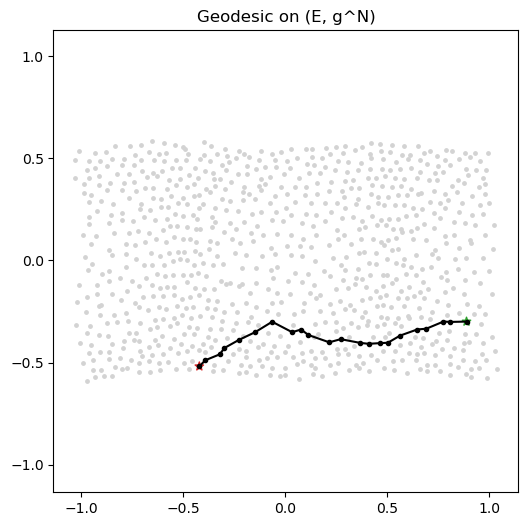

In [17]:
from mgw import plotting
importlib.reload(plotting)

D_M, pred_M = plotting.geodesics_with_predecessors(s, G_M_cpu, G_s)
D_N, pred_N = plotting.geodesics_with_predecessors(t, G_N_cpu, G_t)

i1, i2 = 10, 250

plotting.plot_geodesic_on_base(s, pred_M, i1, i2, title='Geodesic on (E, g^M)')

# Plot geodesic path on (E, g^N) — pick indices in the target set’s index range
j1, j2 = 10, 250
plotting.plot_geodesic_on_base(t, pred_N, j1, j2, title='Geodesic on (E, g^N)')


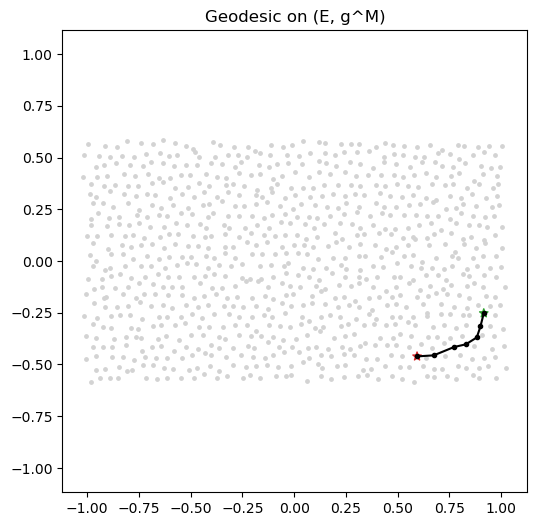

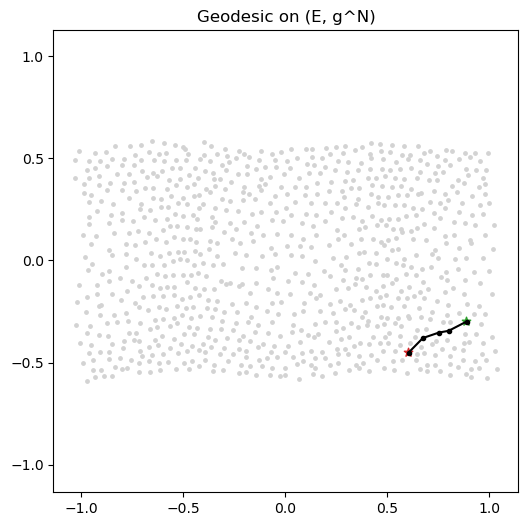

In [18]:
i1, i2 = 100, 250

plotting.plot_geodesic_on_base(s, pred_M, i1, i2, title='Geodesic on (E, g^M)')

# Plot geodesic path on (E, g^N) — pick indices in the target set’s index range
j1, j2 = 100, 250
plotting.plot_geodesic_on_base(t, pred_N, j1, j2, title='Geodesic on (E, g^N)')
